# cardekho.com 

## SETUP

In [1]:
#Import standard libraries
#testing git update 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, MaxAbsScaler,RobustScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest
pd.set_option("display.max_rows",None)

from google.cloud import bigquery

# READ DATA

###Authenticate bigquery

In [4]:
# Install the Google Cloud BigQuery library
!pip install --user google-cloud-bigquery==1.25.0

     |████████████████████████████████| 169 kB 7.3 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 1.42.0 requires google-resumable-media<3.0dev,>=1.3.0; python_version >= "3.6", but you have google-resumable-media 0.5.1 which is incompatible.


### Pull the dataframe from bigquery

In [2]:
%%bigquery df
# SQL query to get a fields from dataset which prints the 10 records
SELECT 
    *
# TODO 3
FROM
    `linear_regression.car_dekho`



# EXPLORE AND CLEAN DATA


In [3]:
df.shape

(4340, 8)

In [6]:
# Make a copy of the original
data = df.copy()

# The first word in the name columns looks like the manufacturer of the car.
# Since, we are not provided with this information in a separate column, we can
# extract it from the "name" column.
#data["manufacturer"] = data.name.str.split(n=1,expand=True)[0]
#data = data.drop("name",axis=1)

### EDA

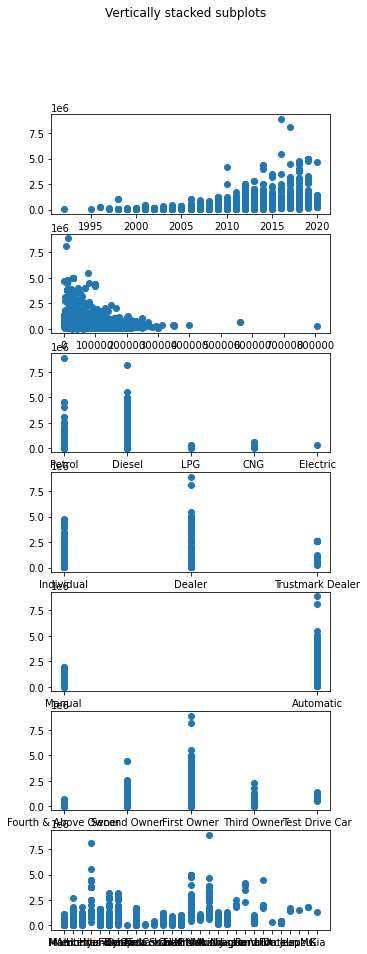

In [6]:
re_arrange_cols = ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'manufacturer', 'selling_price']

data = data[re_arrange_cols]

fig, (ax1, ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7)
fig.suptitle('Vertically stacked subplots')
fig.set_figheight(15)
fig.set_figwidth(5)
ax1.scatter(data.year, data.selling_price)
ax2.scatter(data.km_driven, data.selling_price)
ax3.scatter(data.fuel, data.selling_price)
ax4.scatter(data.seller_type, data.selling_price)
ax5.scatter(data.transmission, data.selling_price)
ax6.scatter(data.owner, data.selling_price)
ax7.scatter(data.manufacturer, data.selling_price)



In [ ]:
re_arrange_cols = ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'manufacturer', 'selling_price']

data = data[re_arrange_cols]

fig, (ax1, ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7)
fig.suptitle('Vertically stacked subplots')
fig.set_figheight(20)
fig.set_figwidth(10)
ax1.hist(data.year)
ax2.hist(data.km_driven)
ax3.hist(data.fuel)
ax4.hist(data.seller_type)
ax5.hist(data.transmission)
ax6.hist(data.owner)
ax7.hist(data.manufacturer)

In [7]:
# Select just the rows desired from the 'describe' method and add in the 'median'
#Check the min,max, mean,median,range and iqr for the numeric fields
stats_df = data.describe()
stats_df.loc['range'] = stats_df.loc['max'] - stats_df.loc['min']

out_fields = ['min','max','mean','25%','50%','75%','range']
stats_df = stats_df.loc[out_fields]

stats_df.rename({'50%':'median','25%':'q25','75%':'q75'},inplace=True)

stats_df.loc['iqr'] = stats_df.loc['q75'] - stats_df.loc['q25']

stats_df.T

# year: range shows that our data is spread over 28 years, staring from
# 1992 and ending in 2020. 
# Selling price range from 20000 to 89000000
#km driven range frmo 1 to 806599 

,min,max,mean,q25,median,q75,range,iqr
year,1992.0,2020.0,2013.090783,2011.00,2014.0,2016.0,28.0,5.00
km_driven,1.0,806599.0,66215.777419,35000.00,60000.0,90000.0,806598.0,55000.00
selling_price,20000.0,8900000.0,504127.311751,208749.75,350000.0,600000.0,8880000.0,391250.25


In [ ]:
#applying multiple functions at once - 2 methods
data.groupby('transmission').agg(['mean','median'])
#Shows Automatic cars sells for more and also newer


year            km_driven        selling_price         
                     mean median          mean median          mean   median
transmission                                                                
Automatic     2015.895939   2017  44462.824873  38500  1.526170e+06  1100000
Manual        2014.857143   2015  60548.743961  52600  4.792861e+05   425000

In [ ]:
data.groupby('manufacturer').agg('mean','median')

,year,km_driven,selling_price
manufacturer,,,
Ambassador,2012.000000,50000.000000,4.300000e+05
Audi,2014.018182,63937.872727,2.014509e+06
BMW,2016.314286,43869.828571,3.174000e+06
Chevrolet,2013.198582,67986.418440,2.622482e+05
Datsun,2016.513514,29564.351351,2.970269e+05
Fiat,2014.090909,74792.636364,3.670909e+05
Force,2014.000000,37516.000000,3.460000e+05
Ford,2015.307692,58595.671795,6.581538e+05
Honda,2015.527094,50184.349754,6.113300e+05


# FEATURE ENGINEERING

### Explore Target

<AxesSubplot:xlabel='selling_price', ylabel='Density'>

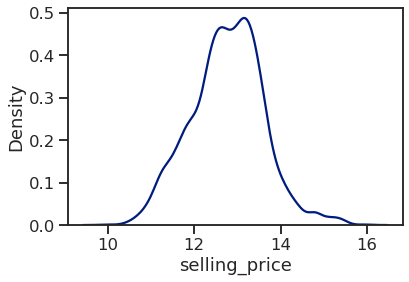

In [26]:
sns.kdeplot(np.log(df.selling_price))

In [27]:
normaltest(np.log(df.selling_price))

NormaltestResult(statistic=13.155628356574784, pvalue=0.0013908862038200577)

<AxesSubplot:ylabel='Density'>

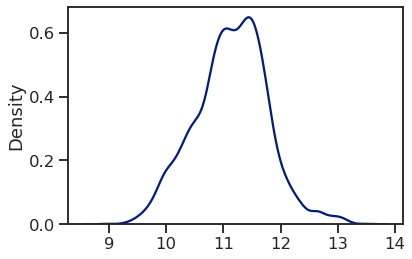

In [28]:
#test boxcox
target_boxcox = boxcox(df.selling_price)
sns.kdeplot(target_boxcox[0])

### Set up prediction

In [8]:
#Create subset of data for prediction
all_cols = ['year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'name']
sub_cols = [ 'year','km_driven','name','transmission','fuel','seller_type', 'selling_price']
small_data = data[all_cols]
small_data.selling_price = boxcox(small_data.selling_price)[0]


In [9]:
# Do the one hot encoding
# Lets find the colms which need one hot encoding
ohc_cols = small_data.columns[small_data.dtypes == "object"]
print(ohc_cols)
# Determine how many extra columns would be created
num_ohc_cols = (small_data[ohc_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))
# Copy of the data
data_ohc = small_data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    print(col)
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)


Index(['fuel', 'seller_type', 'transmission', 'owner', 'name'], dtype='object')
name
fuel
owner
seller_type
transmission


# FIT AND PREDICT

###Split the data with KFold

In [10]:
X = data_ohc.drop('selling_price', axis = 1)
y = data_ohc.selling_price


In [11]:
kf = KFold(shuffle=True, random_state=72018,n_splits=3)

In [12]:
for train_index,test_index in kf.split(X):
  print("Train index:",train_index[:10],len(train_index))
  print("Test index:", test_index[:10],len(test_index))
  print('')

Train index: [ 0  2  3  4  5  7  8  9 10 11] 2893
Test index: [ 1  6 14 15 17 18 20 22 26 30] 1447

Train index: [ 0  1  2  4  6  7  8 10 11 12] 2893
Test index: [ 3  5  9 16 19 21 23 24 27 31] 1447

Train index: [ 1  3  5  6  9 14 15 16 17 18] 2894
Test index: [ 0  2  4  7  8 10 11 12 13 25] 1446



###Define pipeline

In [13]:
s = StandardScaler()
r = RobustScaler()
lr = LinearRegression()
mi = MinMaxScaler()
max = MaxAbsScaler()

#estimator = Pipeline([("scaler",max), ("regression",lr)])
estimator = Pipeline([("regression",lr)])

###Get predictions

In [14]:
predictions = cross_val_predict(estimator,X,y, cv=kf)

In [15]:
y_series = pd.Series(y)
p_series = pd.Series(predictions)
frame = { 'y': y, 'p': predictions }

pd.DataFrame(frame).head(5)



,y,p
0,9.639541,8.865270
1,10.143125,-2643.034632
2,10.718447,10.152108
3,10.889089,10.546127
4,9.639541,9.407433


In [16]:
r2_score(y,predictions)

-178581631960.87598

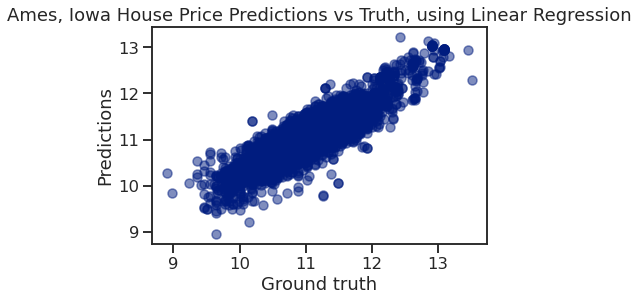

In [15]:

sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y, predictions, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Ames, Iowa House Price Predictions vs Truth, using Linear Regression');

##Tune Hyperparameters

In [17]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [18]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([        
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.60407895838418, tolerance: 0.11979868407987752
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.1741851317124, tolerance: 0.11400585707424443
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.800677775504024, tolerance: 0.11652334613701712
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.071

In [19]:
list(zip(alphas,scores))

[(1e-09, 0.8036138082797633),
 (1e-08, 0.8382774887410896),
 (1e-07, 0.8405065593188167),
 (1e-06, 0.8408492704449193),
 (1e-05, 0.8428033712961572),
 (0.0001, 0.8229989406164365),
 (0.001, 0.7039954304553759),
 (0.01, 0.6776573132571964),
 (0.1, 0.48879777077893616),
 (1.0, 0.32014922213220254)]

In [25]:
Lasso(alpha=1e-05).fit(X, y).coef_

array([ 8.31887859e-02, -5.88241361e-07, -3.92698113e-02, ...,
        7.35634720e-02,  5.02410058e-01, -1.59450148e-16])

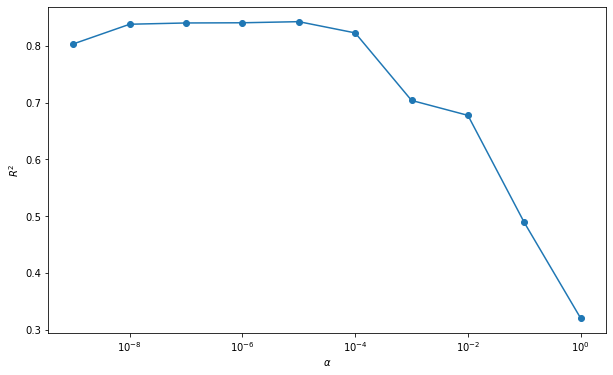

In [28]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [40]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
#best_estimator = Pipeline([                   
#                    ("make_higher_degree", PolynomialFeatures(degree=2)),
#                    ("lasso_regression", Lasso(alpha=0.01))
#                 ])

best_estimator = Pipeline([                   
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("regression", lr)
                 ])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.8228554485954538

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.4484e-24): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.22757e-24): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.05445e-24): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.75212e-24): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4244e-24): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgW

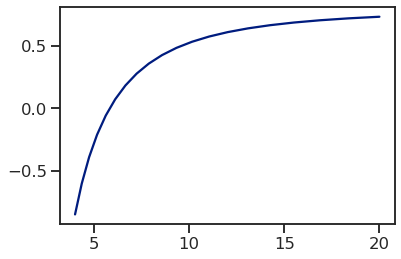

In [42]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

In [52]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
#best_estimator = Pipeline([
#                    ("scaler", s),
#                    ("make_higher_degree", PolynomialFeatures(degree=2)),
#                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("regression", lr)
])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.8228554485954538

In [54]:
#df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
#                 best_estimator.named_steps["lasso_regression"].coef_,
#))
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
                 best_estimator.named_steps["regression"].coef_,
))


In [55]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [56]:
col_names_dict

{0: 'year',
 1: 'km_driven',
 2: 'manufacturer_0',
 3: 'manufacturer_1',
 4: 'manufacturer_2',
 5: 'manufacturer_3',
 6: 'manufacturer_4',
 7: 'manufacturer_5',
 8: 'manufacturer_6',
 9: 'manufacturer_7',
 10: 'manufacturer_8',
 11: 'manufacturer_9',
 12: 'manufacturer_10',
 13: 'manufacturer_11',
 14: 'manufacturer_12',
 15: 'manufacturer_13',
 16: 'manufacturer_14',
 17: 'manufacturer_15',
 18: 'manufacturer_16',
 19: 'manufacturer_17',
 20: 'manufacturer_18',
 21: 'manufacturer_19',
 22: 'manufacturer_20',
 23: 'manufacturer_21',
 24: 'manufacturer_22',
 25: 'manufacturer_23',
 26: 'manufacturer_24',
 27: 'manufacturer_25',
 28: 'manufacturer_26',
 29: 'manufacturer_27',
 30: 'manufacturer_28',
 31: 'fuel_0',
 32: 'fuel_1',
 33: 'fuel_2',
 34: 'fuel_3',
 35: 'fuel_4',
 36: 'seller_type_0',
 37: 'seller_type_1',
 38: 'seller_type_2',
 39: 'transmission_0',
 40: 'transmission_1'}

In [57]:
df_importances.sort_values(by=1)

,0,1
713,x22^2,-7.126464e+01
23,x22,-7.124434e+01
726,x22 x35,-3.797802e+01
730,x22 x39,-3.797802e+01
727,x22 x36,-3.596758e+01
728,x22 x37,-3.529706e+01
723,x22 x32,-3.328663e+01
731,x22 x40,-3.328663e+01
798,x27^2,-2.591345e+01
28,x27,-2.586126e+01


## Grid Search CV

To do cross-validation, we used two techniques:

use KFolds and manually create a loop to do cross-validation
use cross_val_predict and score to get a cross-valiated score in a couple of lines.
To do hyper-parameter tuning, we see a general pattern:

use cross_val_predict and score in a manually written loop over hyperparemeters, then select the best one.
Perhaps not surprisingly, there is a function that does this for us -- GridSearchCV

### Ridge

In [18]:
# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [19]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [83]:
grid.best_score_, grid.best_params_

(0.8025878417677482,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 20.000000000000004})

In [85]:
y_predict = grid.predict(X)

In [86]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.8229145327162037

In [87]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  3.70594964e-01, -4.23534300e-02, -1.58860518e-06,
        1.29565325e-03,  6.54606569e-04, -2.03931233e-03, -4.81906875e-06,
       -1.82263551e-04, -1.16907042e-05,  3.61103575e-07,  6.16521020e-04,
        2.81419580e-03,  5.33264963e-03,  4.05731733e-06,  6.14163191e-05,
        2.21672512e-05,  2.33726234e-06,  7.87586715e-05,  1.20564996e-05,
        4.33892758e-03, -6.81275618e-03,  8.60469490e-04,  2.89015103e-05,
        8.61605989e-05,  1.46691078e-05,  1.42379550e-04,  4.45261320e-04,
       -7.28719555e-03,  4.57068966e-03,  6.39134802e-04,  4.31077254e-05,
       -1.82097621e-04,  7.68604162e-02, -2.52165665e-06, -6.21006711e-05,
       -7.68321846e-02,  4.85883676e-03, -5.31938438e-03,  1.77804679e-03,
        3.35676985e-03, -3.35676985e-03,  1.50370765e-02,  1.42989567e-03,
       -2.93504242e-03,  6.86706838e-04, -5.52327860e-03, -1.19682360e-02,
       -5.61338358e-03, -2.87666025e-02,  9.79114607e-03, -5.62598636e-03,
        1.87204824e-02, -

In [88]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021067,0.009673,0.008253,0.004890,1,4.0,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782295,0.784909,0.797389,0.788198,0.006586,59
1,0.014285,0.000981,0.004365,0.000508,1,4.228267,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782296,0.784907,0.797391,0.788198,0.006587,58
2,0.013519,0.000257,0.004030,0.000105,1,4.46956,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782297,0.784905,0.797393,0.788198,0.006588,56
3,0.013020,0.000138,0.003922,0.000065,1,4.724624,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782298,0.784902,0.797395,0.788198,0.006589,55
4,0.012997,0.000027,0.003867,0.000032,1,4.994243,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782299,0.784899,0.797398,0.788199,0.006591,54
5,0.012979,0.000224,0.003873,0.000055,1,5.279248,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782300,0.784896,0.797400,0.788199,0.006592,53
6,0.013046,0.000023,0.003895,0.000021,1,5.580518,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782302,0.784893,0.797403,0.788199,0.006593,51
7,0.013278,0.000147,0.004147,0.000274,1,5.89898,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782303,0.784890,0.797405,0.788199,0.006595,50
8,0.013287,0.000353,0.003917,0.000030,1,6.235615,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782304,0.784887,0.797408,0.788200,0.006596,49
9,0.013251,0.000092,0.004128,0.000253,1,6.591461,"{'polynomial_features__degree': 1, 'ridge_regr...",0.782306,0.784883,0.797411,0.788200,0.006598,47


## Linear

In [73]:
# Same estimator as before
estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        ("regression", lr)])

params = {
    'polynomial_features__degree': [1, 2, 3],    
}

grid2 = GridSearchCV(estimator, params, cv=kf)

In [74]:
grid2.fit(X,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('regression', LinearRegression())]),
             param_grid={'polynomial_features__degree': [1, 2, 3]})

In [75]:
grid2.best_score_,grid2.best_params_

(0.7885635017266841, {'polynomial_features__degree': 1})

## Lasso

In [23]:
#alphas = np.geomspace(1e-9, 1e0, num=10)

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("lasso_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': np.geomspace(1e-9, 1e0, num=10)
}

grid3 = GridSearchCV(estimator, params, cv=kf)

In [24]:
grid3.fit(X,y)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/opt/conda/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('lasso_regression', Ridge())]),
             param_grid={'lasso_regression__alpha': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00]),
                         'polynomial_features__degree': [1, 2, 3]})

In [79]:
grid3.best_score_,grid3.best_params_

(0.8019508239720018,
 {'lasso_regression__alpha': 1.0, 'polynomial_features__degree': 2})